In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# load datasets
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
#sample = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [5]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


# Check for null

In [9]:
train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0)

**Feature Engineering**

In [10]:
# separate features from the target
X = train.drop('label', axis = 1)
y=train.label

In [11]:
# Normalize features
X = X / 255.0
X_test = X_test / 255.0

In [12]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.80, random_state = 0)

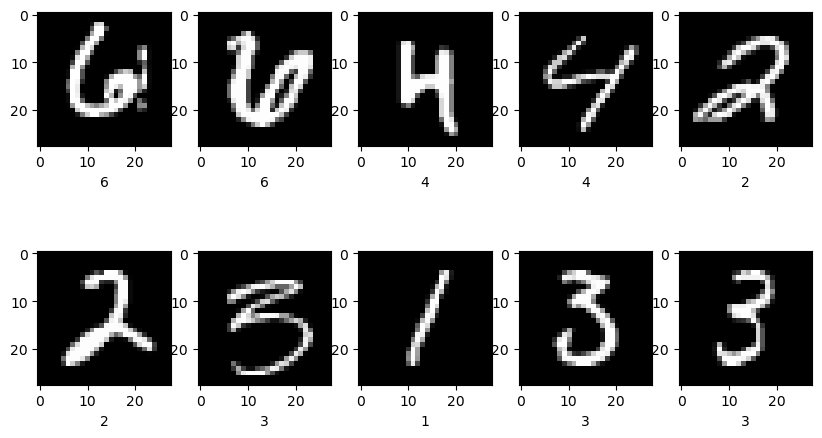

In [13]:
# Reshape the training data to have the shape (num_samples, 28, 28)
X_train_reshaped = X_train.values.reshape(-1, 28, 28)

# create a figure for viz
plt.figure(figsize=(10,15))

# Loop over the 1st 10 images in training data
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.imshow(X_train_reshaped[i], cmap = 'gray')
    actual_label = y_train.iloc[i]
    plt.xlabel(actual_label)
plt.show()

In [14]:
# Reshape the training data to have the shape (num_samples, 28, 28, 1)
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)

# Reshape the validation data to have the shape (num_samples, 28, 28, 1)
X_val_reshaped = X_val.values.reshape(-1, 28, 28, 1)

In [15]:
input_shape = (28, 28, 1)

# Create a Sequential model
model = Sequential([
    # First Convolutional Layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling to downsample the feature maps
    BatchNormalization(),  # Normalize the output for stable training
    
    # Second Convolutional Layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),MaxPooling2D(pool_size=(2, 2)),  # Max pooling to further downsample feature maps
    BatchNormalization(),  # Normalize the output
    
    Flatten(),  # Flatten the feature maps for dense layers
    Dropout(0.3),  # Apply dropout to reduce overfitting
    
    # First Dense Layer
    Dense(units=128, activation='relu'),  # Fully connected layer with ReLU activation
    BatchNormalization(),  # Normalize the output
    Dropout(0.3),  # Apply dropout to further prevent overfitting
    
    # Second Dense Layer
    Dense(units=64, activation='relu'),  # Fully connected layer with ReLU activation
    BatchNormalization(),  # Normalize the output
    Dropout(0.3),  # Apply dropout to further prevent overfitting
    
    # Output Layer
    Dense(units=10, activation='softmax')  # Fully connected layer with softmax for classification
])

In [16]:
# compile the model 
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [17]:
# Callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,             # Minimum change in monitored quantity to qualify as an improvement
    restore_best_weights=True,   # Restore model weights from the epoch with the best value of monitored quantity
)

In [18]:
# Train the model
history = model.fit(
    X_train_reshaped,          # Training data
    y_train,                   # Training labels
    epochs=50,                 # Number of epochs for training
    validation_data=(X_val_reshaped, y_val),  # Validation data and labels
    batch_size=50,             # Number of samples per gradient update
    callbacks=[early_stopping],# List of callbacks to apply during training
    verbose=1                  # Verbosity mode: 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Epoch 1/50
672/672 [==============================] - 29s 39ms/step - loss: 0.2689 - accuracy: 0.9220 - val_loss: 0.0632 - val_accuracy: 0.9814
Epoch 2/50
672/672 [==============================] - 25s 37ms/step - loss: 0.0947 - accuracy: 0.9722 - val_loss: 0.0501 - val_accuracy: 0.9854
Epoch 3/50
672/672 [==============================] - 24s 36ms/step - loss: 0.0727 - accuracy: 0.9785 - val_loss: 0.0468 - val_accuracy: 0.9855
Epoch 4/50
672/672 [==============================] - 24s 36ms/step - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.0397 - val_accuracy: 0.9881
Epoch 5/50
672/672 [==============================] - 24s 35ms/step - loss: 0.0545 - accuracy: 0.9837 - val_loss: 0.0381 - val_accuracy: 0.9898
Epoch 6/50
672/672 [==============================] - 24s 36ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.0320 - val_accuracy: 0.9905
Epoch 7/50
672/672 [==============================] - 25s 36ms/step - loss: 0.0441 - accuracy: 0.9865 - val_loss: 0.0329 - val_accuracy:

In [19]:
# Reshape the validation data to have the shape (num_samples, 28, 28, 1)
X_val_reshaped = X_val.values.reshape(-1, 28, 28, 1)

In [20]:
# Evaluate the trained model on validation data
val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.0320
Validation Accuracy: 0.9905


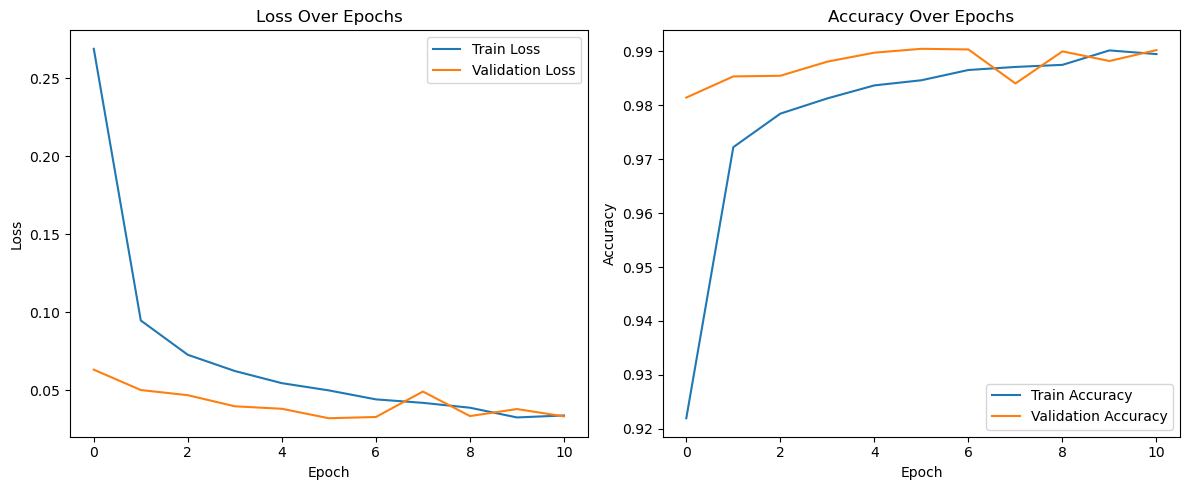

In [21]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)  # Create a subplot with 1 row and 2 columns, select the first subplot
plt.plot(history.history['loss'], label='Train Loss')  # Plot the training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot the validation loss over epochs
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.title('Loss Over Epochs')  # Title for the subplot
plt.legend()  # Display legend for the plotted lines

# Plot accuracy
plt.subplot(1, 2, 2)  # Select the second subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot the training accuracy over epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot the validation accuracy over epochs
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.title('Accuracy Over Epochs')  # Title for the subplot
plt.legend()  # Display legend for the plotted lines

plt.tight_layout()  # Automatically adjust subplot parameters for better layout
plt.show()  # Display the entire figure

In [22]:
# Reshape the test data to have the shape (num_samples, 28, 28, 1)
X_test_reshaped = X_test.values.reshape(-1, 28, 28, 1)

# Predict using the trained model
test_predictions = model.predict(X_test_reshaped)

# Convert predictions to probabilities using softmax
test_predictions_prob = tf.nn.softmax(test_predictions).numpy()

# Get the predicted labels (class with the highest probability)
predicted_labels = test_predictions_prob.argmax(axis=1)


875/875 [==============================] - 7s 8ms/step


1/1 [==============================] - 0s 29ms/step


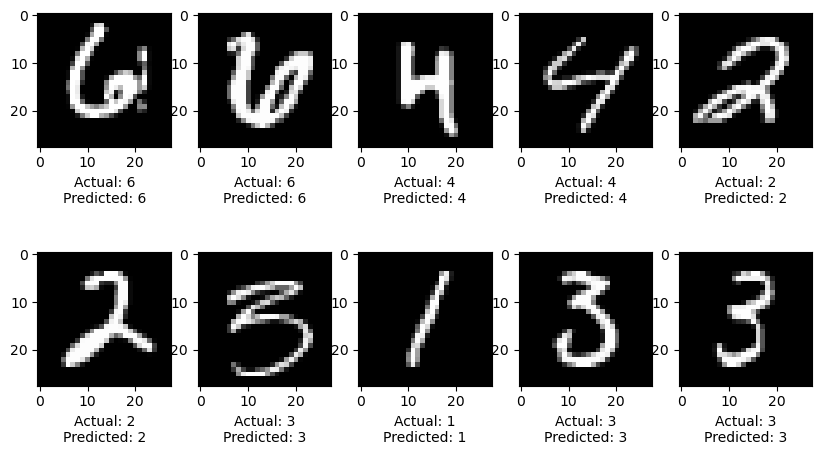

In [23]:
# Visualize 10 images and their actual and predicted labels
plt.figure(figsize=(10, 15))  # Create a figure with a size of 10 units width and 15 units height
for i in range(10):  # Loop through the first 10 images
    plt.subplot(5, 5, i+1)  # Create a subplot with 5 rows and 5 columns, select the current subplot
    plt.grid(False)  # Turn off grid lines
    plt.imshow(X_train_reshaped[i], cmap='gray')  # Display the image using a grayscale colormap
    actual_label = y_train.iloc[i]  # Get the actual label for the current image
    predicted_label = np.argmax(model.predict(np.expand_dims(X_train_reshaped[i], axis=0)))  # Predict the label for the current image
    plt.xlabel(f"Actual: {actual_label}\nPredicted: {predicted_label}")  # Set xlabel with actual and predicted labels
plt.show()  # Display the entire figure

In [24]:
# Create submission file
ImageId = list(range(1, len(test_predictions) + 1))  # Create a list of Image IDs starting from 1
Label = [pred.argmax() for pred in test_predictions]  # Extract the label with the highest probability for each test prediction

# Create a DataFrame for submission
submissions = pd.DataFrame({"ImageId": ImageId, "Label": Label})  # Create a DataFrame with ImageId and Label columns

submissions.to_csv("submission.csv", index=False, header=True)  # Save the DataFrame as a CSV file named "submission.csv"